In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

## Load data

In [2]:
df = pd.read_excel('PSG_sleep_index_20220928.xlsx')

In [3]:
X = scale(df.iloc[:, 10:19]) # k to s column
y1 = df[['(A6①)寝つきの良さ']]
y2 = df[['(A6③)眠りの深さ']]
y3 = df[['(A6⑤)全体的な睡眠の質']]

feature_names = df.columns[10:19]
len(X)

309

In [4]:
df_filtered = df[~df['(A6⑤)全体的な睡眠の質'].isin([3])].copy()

# bad is 1, good is 2
df_filtered['(A6⑤)全体的な睡眠の質'] = df_filtered['(A6⑤)全体的な睡眠の質'].apply(lambda x: 2 if x in [1, 2] else 1)

X_filtered = scale(df_filtered.iloc[:, 10:19])  
y3_filtered = df_filtered[['(A6⑤)全体的な睡眠の質']]

len(X_filtered)

201

In [5]:
sleep_quality_counts = df_filtered['(A6⑤)全体的な睡眠の質'].value_counts()
print(sleep_quality_counts)

(A6⑤)全体的な睡眠の質
1    139
2     62
Name: count, dtype: int64


In [6]:
ros = RandomOverSampler(random_state=0)
X_filtered, y3_filtered = ros.fit_resample(X_filtered, y3_filtered)

len(X_filtered)

278

In [7]:
y3_filtered_series = y3_filtered.iloc[:, 0]
print(y3_filtered_series.value_counts())

(A6⑤)全体的な睡眠の質
1    139
2    139
Name: count, dtype: int64


## L2（なし）

In [ ]:
ridge = Ridge(alpha=1)

scores = cross_validate(ridge, X, y1, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

In [ ]:
ridge = Ridge(alpha=1)

scores = cross_validate(ridge, X, y2, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

In [ ]:
ridge = Ridge(alpha=1)

scores = cross_validate(ridge, X, y3, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

## Lasso Regression（なし）

### (A6①)寝つきの良さ

In [ ]:
lasso = Lasso(alpha=0.01)

In [ ]:
scores = cross_validate(lasso, X, y1, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

### (A6③)眠りの深さ

In [ ]:
lasso = Lasso(alpha=0.01)

In [ ]:
scores = cross_validate(lasso, X, y2, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

### (A6⑤)全体的な睡眠の質

In [ ]:
lasso = Lasso(alpha=0.01)

In [ ]:
scores = cross_validate(lasso, X, y3, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

## Desicion Tree（なし）

### (A6①)寝つきの良さ

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor().fit(X, y1)
importances = tree.feature_importances_
print(importances)

In [ ]:
scores = cross_val_score(tree, X, y1, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

In [ ]:
tree = DecisionTreeClassifier(max_depth=2).fit(X, y1)

In [ ]:
scores = cross_validate(tree, X, y1, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

### (A6③)眠りの深さ

In [ ]:
tree = DecisionTreeRegressor().fit(X, y2)
importances = tree.feature_importances_
print(importances)

In [ ]:
scores = cross_val_score(tree, X, y2, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

In [ ]:
tree = DecisionTreeClassifier(max_depth=4).fit(X, y2)

In [ ]:
scores = cross_validate(tree, X, y2, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

### (A6⑤)全体的な睡眠の質

In [ ]:
tree = DecisionTreeRegressor().fit(X, y3)
importances = tree.feature_importances_
print(importances)

In [ ]:
scores = cross_val_score(tree, X, y3, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

In [ ]:
tree = DecisionTreeClassifier(max_depth=4).fit(X, y3)

In [ ]:
scores = cross_validate(tree, X, y3, return_train_score=True, cv=10)

average_test_score = scores['test_score'].mean()
average_train_score = scores['train_score'].mean()
print("Train R2 score: {:.4f}".format(average_train_score))
print("Test R2 score: {:.4f}".format(average_test_score))

## SV

In [8]:
from sklearn.svm import SVR
from sklearn.svm import SVC

In [9]:
from sklearn.utils import column_or_1d
y1 = column_or_1d(y1, warn=True)
y2 = column_or_1d(y2, warn=True)
y3 = column_or_1d(y3, warn=True)

/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_66523/1553019768.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y1 = column_or_1d(y1, warn=True)
/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_66523/1553019768.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y2 = column_or_1d(y2, warn=True)
/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_66523/1553019768.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y3 = column_or_1d(y3, warn=True)


In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [11]:
def round_predictions(predictions):
    rounded_predictions = np.where(predictions < 1.5, 1, 
                           np.where(predictions < 2.5, 2, 
                           np.where(predictions < 3.5, 3, 
                           np.where(predictions < 4.5, 4, 5))))
    return rounded_predictions

In [22]:
kf = KFold(n_splits=10)

predictions1, true_y1, rounded_predictions1 = [], [], []
predictions2, true_y2, rounded_predictions2 = [], [], []
predictions3, true_y3, rounded_predictions3 = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    y3_train, y3_test = y3[train_index], y3[test_index]
    
    # fit
    svr1 = SVR(kernel='rbf', gamma=0.01, C=1).fit(X_train, y1_train)
    svr2 = SVR(kernel='rbf', gamma=0.01, C=1).fit(X_train, y2_train)
    svr3 = SVR(kernel='rbf', gamma=0.01, C=1).fit(X_train, y3_train)
    
    # predict
    y1_pred = svr1.predict(X_test)
    y2_pred = svr2.predict(X_test)
    y3_pred = svr3.predict(X_test)

    predictions1.append(y1_pred)
    predictions2.append(y2_pred)
    predictions3.append(y3_pred)
    true_y1.append(y1_test) 
    true_y2.append(y2_test)  
    true_y3.append(y3_test)
    
predictions1 = np.concatenate(predictions1)
predictions2 = np.concatenate(predictions2)
predictions3 = np.concatenate(predictions3)
true_values1 = np.concatenate(true_y1)
true_values2 = np.concatenate(true_y2)
true_values3 = np.concatenate(true_y3)
rounded_predictions1 = round_predictions(predictions1)    
rounded_predictions2 = round_predictions(predictions2) 
rounded_predictions3 = round_predictions(predictions3) 

rmse1 = mean_squared_error(true_values1, rounded_predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, rounded_predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, rounded_predictions3, squared=False)
r2_1 = r2_score(true_values1, rounded_predictions1)
r2_2 = r2_score(true_values2, rounded_predictions2)
r2_3 = r2_score(true_values3, rounded_predictions3)
print("RMSE for rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))
print("--------------------------------------------------------------")

rmse1 = mean_squared_error(true_values1, predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, predictions3, squared=False)
r2_1 = r2_score(true_values1, predictions1)
r2_2 = r2_score(true_values2, predictions2)
r2_3 = r2_score(true_values3, predictions3)
print("RMSE for no rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for no rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for no rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for no rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))

RMSE for rounded (A6①)寝つきの良さ: 0.9138
RMSE for rounded (A6③)眠りの深さ: 0.9084
RMSE for rounded (A6⑤)全体的な睡眠の質: 0.9688
R2 score for rounded (A6①)寝つきの良さ: 0.0187
R2 score for rounded (A6③)眠りの深さ: 0.0228
R2 score for rounded (A6⑤)全体的な睡眠の質: -0.0982
--------------------------------------------------------------
RMSE for no rounded (A6①)寝つきの良さ: 0.8957
RMSE for no rounded (A6③)眠りの深さ: 0.8442
RMSE for no rounded (A6⑤)全体的な睡眠の質: 0.9306
R2 score for no rounded (A6①)寝つきの良さ: 0.0572
R2 score for no rounded (A6③)眠りの深さ: 0.1562
R2 score for no rounded (A6⑤)全体的な睡眠の質: -0.0133


In [13]:
from sklearn.model_selection import LeaveOneOut

In [27]:
y3_filtered = column_or_1d(y3_filtered, warn=True)

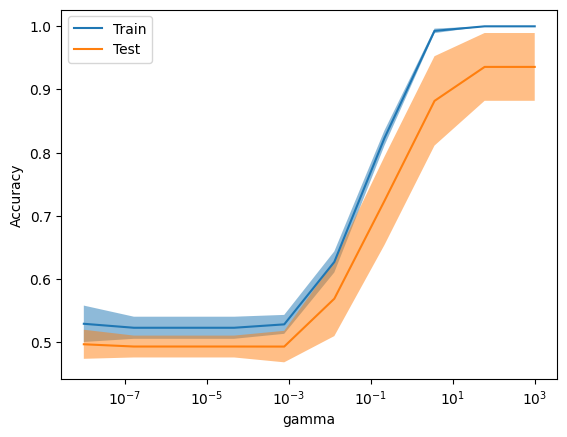

In [28]:
param_range = np.logspace(-8, 3, 10)


train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', C=1), X_filtered, y3_filtered, 
    param_name="gamma", param_range=param_range
)


display = ValidationCurveDisplay(
     param_name="gamma", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

In [35]:
test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

Best gamma value for highest test score: 59.94842503189421


In [36]:
loo = LeaveOneOut()
svc = SVC(kernel='rbf', gamma=59.94, C=1).fit(X_filtered, y3_filtered)
scores = cross_validate(svc, X_filtered, y3_filtered, cv=loo, return_train_score=True)

average_test_score = scores['test_score'].mean()

print("Test data Accuracy for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score))

Test data Accuracy for (A6⑤)全体的な睡眠の質: 0.9496


## AdaBoost（なし）

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
ada1 = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X, y1)
ada2 = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X, y2)
ada3 = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X, y3)
scores1 = cross_validate(ada1, X, y1, return_train_score=True, cv=10)
scores2 = cross_validate(ada2, X, y2, return_train_score=True, cv=10)
scores3 = cross_validate(ada3, X, y3, return_train_score=True, cv=10)

average_test_score1 = scores1['test_score'].mean()
average_train_score1 = scores1['train_score'].mean()
average_test_score2 = scores2['test_score'].mean()
average_train_score2 = scores2['train_score'].mean()
average_test_score3 = scores3['test_score'].mean()
average_train_score3 = scores3['train_score'].mean()
print("Train R2 score for (A6①)寝つきの良さ: {:.4f}".format(average_train_score1))
print("Test R2 scorefor (A6①)寝つきの良さ: {:.4f}".format(average_test_score1))
print("Train R2 score for (A6③)眠りの深さ: {:.4f}".format(average_train_score2))
print("Test R2 scorefor (A6③)眠りの深さ: {:.4f}".format(average_test_score2))
print("Train R2 score for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_train_score3))
print("Test R2 scorefor (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score3))

In [ ]:
ada1 = AdaBoostClassifier(random_state=0, n_estimators=50).fit(X, y1)
ada2 = AdaBoostClassifier(random_state=0, n_estimators=50).fit(X, y2)
ada3 = AdaBoostClassifier(random_state=0, n_estimators=50).fit(X, y3)
scores1 = cross_validate(ada1, X, y1, return_train_score=True, cv=10)
scores2 = cross_validate(ada2, X, y2, return_train_score=True, cv=10)
scores3 = cross_validate(ada3, X, y3, return_train_score=True, cv=10)

average_test_score1 = scores1['test_score'].mean()
average_train_score1 = scores1['train_score'].mean()
average_test_score2 = scores2['test_score'].mean()
average_train_score2 = scores2['train_score'].mean()
average_test_score3 = scores3['test_score'].mean()
average_train_score3 = scores3['train_score'].mean()
print("Train R2 score for (A6①)寝つきの良さ: {:.4f}".format(average_train_score1))
print("Test R2 scorefor (A6①)寝つきの良さ: {:.4f}".format(average_test_score1))
print("Train R2 score for (A6③)眠りの深さ: {:.4f}".format(average_train_score2))
print("Test R2 scorefor (A6③)眠りの深さ: {:.4f}".format(average_test_score2))
print("Train R2 score for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_train_score3))
print("Test R2 scorefor (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score3))

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [23]:
kf = KFold(n_splits=10)

predictions1, true_y1, rounded_predictions1 = [], [], []
predictions2, true_y2, rounded_predictions2 = [], [], []
predictions3, true_y3, rounded_predictions3 = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    y3_train, y3_test = y3[train_index], y3[test_index]
    
    # fit
    forest1 = RandomForestRegressor(max_depth=3, n_estimators=200, random_state=0).fit(X_train, y1_train)
    forest2 = RandomForestRegressor(max_depth=3, n_estimators=200, random_state=0).fit(X_train, y2_train)
    forest3 = RandomForestRegressor(max_depth=3, n_estimators=200, random_state=0).fit(X_train, y3_train)
    
    # predict
    y1_pred = forest1.predict(X_test)
    y2_pred = forest2.predict(X_test)
    y3_pred = forest3.predict(X_test)

    predictions1.append(y1_pred)
    predictions2.append(y2_pred)
    predictions3.append(y3_pred)
    true_y1.append(y1_test) 
    true_y2.append(y2_test)  
    true_y3.append(y3_test)
    
predictions1 = np.concatenate(predictions1)
predictions2 = np.concatenate(predictions2)
predictions3 = np.concatenate(predictions3)
true_values1 = np.concatenate(true_y1)
true_values2 = np.concatenate(true_y2)
true_values3 = np.concatenate(true_y3)
rounded_predictions1 = round_predictions(predictions1)    
rounded_predictions2 = round_predictions(predictions2) 
rounded_predictions3 = round_predictions(predictions3) 

rmse1 = mean_squared_error(true_values1, rounded_predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, rounded_predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, rounded_predictions3, squared=False)
r2_1 = r2_score(true_values1, rounded_predictions1)
r2_2 = r2_score(true_values2, rounded_predictions2)
r2_3 = r2_score(true_values3, rounded_predictions3)
print("RMSE for rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))
print("--------------------------------------------------------------")

rmse1 = mean_squared_error(true_values1, predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, predictions3, squared=False)
r2_1 = r2_score(true_values1, predictions1)
r2_2 = r2_score(true_values2, predictions2)
r2_3 = r2_score(true_values3, predictions3)
print("RMSE for no rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for no rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for no rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for no rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))

RMSE for rounded (A6①)寝つきの良さ: 0.9519
RMSE for rounded (A6③)眠りの深さ: 0.9049
RMSE for rounded (A6⑤)全体的な睡眠の質: 1.0000
R2 score for rounded (A6①)寝つきの良さ: -0.0650
R2 score for rounded (A6③)眠りの深さ: 0.0305
R2 score for rounded (A6⑤)全体的な睡眠の質: -0.1702
--------------------------------------------------------------
RMSE for no rounded (A6①)寝つきの良さ: 0.8736
RMSE for no rounded (A6③)眠りの深さ: 0.8485
RMSE for no rounded (A6⑤)全体的な睡眠の質: 0.9267
R2 score for no rounded (A6①)寝つきの良さ: 0.1031
R2 score for no rounded (A6③)眠りの深さ: 0.1475
R2 score for no rounded (A6⑤)全体的な睡眠の質: -0.0050


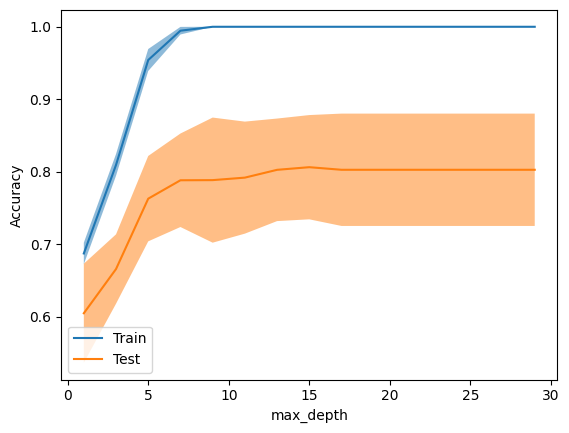

In [37]:
param_range = np.arange(1, 31, 2)


train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100,random_state=0), X_filtered, y3_filtered, 
    param_name="max_depth", param_range=param_range
)


display = ValidationCurveDisplay(
     param_name="max_depth", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

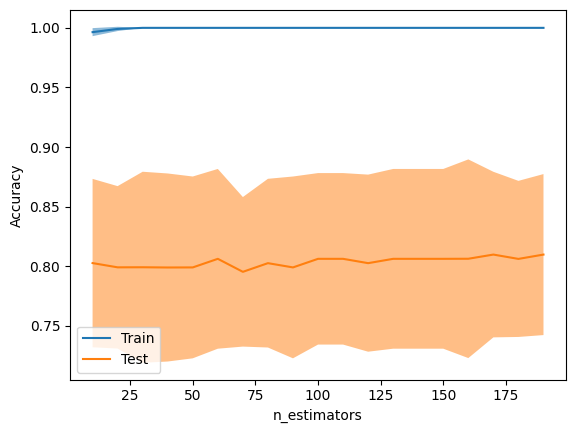

In [39]:
param_range = np.arange(10, 200, 10)


train_scores, test_scores = validation_curve(
    RandomForestClassifier(max_depth=15, random_state=0), X_filtered, y3_filtered, 
    param_name="n_estimators", param_range=param_range
)


display = ValidationCurveDisplay(
     param_name="n_estimators", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

In [40]:
loo = LeaveOneOut()
forest = RandomForestClassifier(max_depth=15, n_estimators=60,random_state=0).fit(X_filtered, y3_filtered)
scores = cross_validate(forest, X_filtered, y3_filtered, cv=loo, return_train_score=True)

average_test_score = scores['test_score'].mean()

print("Test data Accuracy for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score))

Test data Accuracy for (A6⑤)全体的な睡眠の質: 0.8633


## MLP

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

In [24]:
kf = KFold(n_splits=10)

predictions1, true_y1, rounded_predictions1 = [], [], []
predictions2, true_y2, rounded_predictions2 = [], [], []
predictions3, true_y3, rounded_predictions3 = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    y3_train, y3_test = y3[train_index], y3[test_index]
    
    # fit
    mlp1 = MLPRegressor(random_state=1, hidden_layer_sizes=400, max_iter=1000, early_stopping=True).fit(X_train, y1_train)
    mlp2 = MLPRegressor(random_state=1, hidden_layer_sizes=400, max_iter=1000, early_stopping=True).fit(X_train, y2_train)
    mlp3 = MLPRegressor(random_state=1, hidden_layer_sizes=400, max_iter=1000, early_stopping=True).fit(X_train, y3_train)
    
    # predict
    y1_pred = mlp1.predict(X_test)
    y2_pred = mlp2.predict(X_test)
    y3_pred = mlp3.predict(X_test)

    predictions1.append(y1_pred)
    predictions2.append(y2_pred)
    predictions3.append(y3_pred)
    true_y1.append(y1_test) 
    true_y2.append(y2_test)  
    true_y3.append(y3_test)
    
predictions1 = np.concatenate(predictions1)
predictions2 = np.concatenate(predictions2)
predictions3 = np.concatenate(predictions3)
true_values1 = np.concatenate(true_y1)
true_values2 = np.concatenate(true_y2)
true_values3 = np.concatenate(true_y3)
rounded_predictions1 = round_predictions(predictions1)    
rounded_predictions2 = round_predictions(predictions2) 
rounded_predictions3 = round_predictions(predictions3) 

rmse1 = mean_squared_error(true_values1, rounded_predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, rounded_predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, rounded_predictions3, squared=False)
r2_1 = r2_score(true_values1, rounded_predictions1)
r2_2 = r2_score(true_values2, rounded_predictions2)
r2_3 = r2_score(true_values3, rounded_predictions3)
print("RMSE for rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))
print("--------------------------------------------------------------")

rmse1 = mean_squared_error(true_values1, predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, predictions3, squared=False)
r2_1 = r2_score(true_values1, predictions1)
r2_2 = r2_score(true_values2, predictions2)
r2_3 = r2_score(true_values3, predictions3)
print("RMSE for no rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for no rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for no rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for no rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))

RMSE for rounded (A6①)寝つきの良さ: 1.0271
RMSE for rounded (A6③)眠りの深さ: 1.0048
RMSE for rounded (A6⑤)全体的な睡眠の質: 1.0943
R2 score for rounded (A6①)寝つきの良さ: -0.2399
R2 score for rounded (A6③)眠りの深さ: -0.1956
R2 score for rounded (A6⑤)全体的な睡眠の質: -0.4012
--------------------------------------------------------------
RMSE for no rounded (A6①)寝つきの良さ: 0.9613
RMSE for no rounded (A6③)眠りの深さ: 0.9364
RMSE for no rounded (A6⑤)全体的な睡眠の質: 1.0561
R2 score for no rounded (A6①)寝つきの良さ: -0.0861
R2 score for no rounded (A6③)眠りの深さ: -0.0383
R2 score for no rounded (A6⑤)全体的な睡眠の質: -0.3052


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

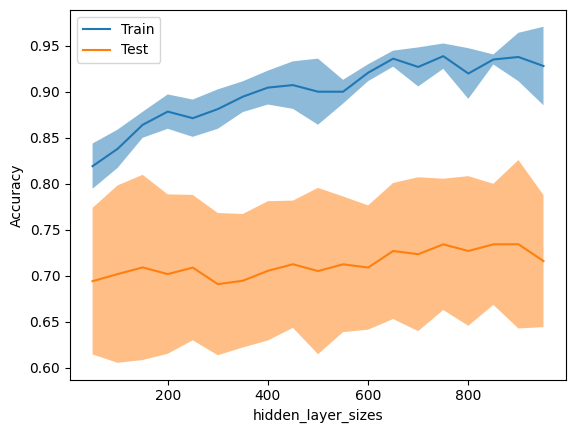

In [45]:
param_range = np.arange(50, 1000, 50)


train_scores, test_scores = validation_curve(
    MLPClassifier(random_state=1, max_iter=500), X_filtered, y3_filtered, 
    param_name="hidden_layer_sizes", param_range=param_range
)


display = ValidationCurveDisplay(
     param_name="hidden_layer_sizes", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

In [46]:
loo = LeaveOneOut()
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=750, max_iter=500).fit(X_filtered, y3_filtered)
scores = cross_validate(mlp, X_filtered, y3_filtered, cv=loo, return_train_score=True)

average_test_score = scores['test_score'].mean()

print("Test data Accuracy for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Test data Accuracy for (A6⑤)全体的な睡眠の質: 0.7878


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
